## Import Libraries

In [1]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline  
import glob  # Filename pattern matching
import random  
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch  
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split  

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise CPU
print("Using {} device".format(device))  # Print the selected device

Using cuda device


In [3]:
def set_seed(seed=0):  # Function to set random seed for reproducibility
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  
    torch.manual_seed(seed)  # 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed)  
    random.seed(seed)  

set_seed() 

## Load files path in a dataframe

In [4]:
ROOT_PATH = '../input/lgg-mri-segmentation/kaggle_3m/'

# Using glob.glob to collect paths of all mask files in subdirectories 
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining a function diagnosis(mask_path) that returns 1 
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
...,...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [5]:
# Displaying the distribution of diagnoses (0: No Tumor, 1: Tumor) in the DataFrame files_df
# and adding labels indicating the total number of images for each category.
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [6]:
from sklearn.utils import resample
import pandas as pd
import shutil
import os

# Load dataset (assuming files_df contains all image paths and labels)
non_tumor_df = files_df[files_df["diagnosis"] == 0]  # Non-tumor cases
tumor_df = files_df[files_df["diagnosis"] == 1]  # Tumor cases

# Downsample both tumor and non-tumor cases to match 1371
non_tumor_df_sampled = resample(non_tumor_df, replace=False, n_samples=1371, random_state=42)
tumor_df_sampled = resample(tumor_df, replace=False, n_samples=1371, random_state=42)  # Fix

# Merge balanced dataset
balanced_df = pd.concat([tumor_df_sampled, non_tumor_df_sampled]).sample(frac=1).reset_index(drop=True)

# Print new dataset balance
print(f"Balanced Dataset - Tumor Cases: {len(balanced_df[balanced_df['diagnosis'] == 1])}")
print(f"Balanced Dataset - Non-Tumor Cases: {len(balanced_df[balanced_df['diagnosis'] == 0])}")

# Move the selected images & masks to a new folder
os.makedirs("balanced_images", exist_ok=True)
os.makedirs("balanced_masks", exist_ok=True)

for _, row in balanced_df.iterrows():
    shutil.copy(row["image_path"], f"balanced_images/{os.path.basename(row['image_path'])}")
    shutil.copy(row["mask_path"], f"balanced_masks/{os.path.basename(row['mask_path'])}")


Balanced Dataset - Tumor Cases: 1371
Balanced Dataset - Non-Tumor Cases: 1371


In [7]:
print(len(os.listdir("balanced_images")))  # Should be 1371 + 1373 = 2744
print(len(os.listdir("balanced_masks")))   # Should also be 274

2742
2742


In [8]:
# Use the balanced dataset after downsampling
train_df, val_df = train_test_split(balanced_df, stratify=balanced_df['diagnosis'], test_size=0.1, random_state=0)

# Reset index after splitting
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Further split training data to create a test set
train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)

# Reset index again
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#  Print the new dataset distribution
print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (2096, 3)
Val: (275, 3)
Test: (371, 3)


## Viewing the dataset

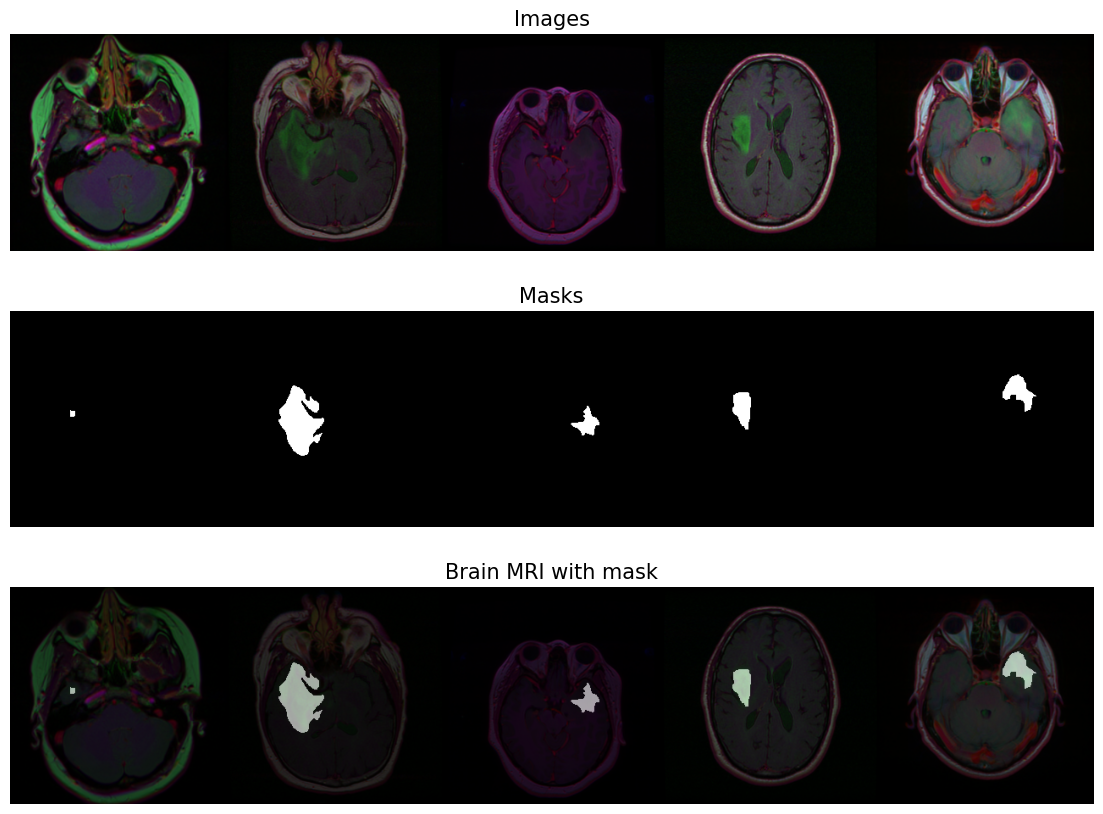

In [10]:
set_seed()
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

set_seed()

# Prepare the images and masks
images, masks = [], []
df_positive = train_df[train_df['diagnosis'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)

# Reverse the order of images and masks
images = np.array(images[4::-1])
masks = np.array(masks[4::-1])

# Concatenate the images and masks horizontally
images_concat = np.hstack(images)
masks_concat = np.hstack(masks)

# Plot the images, masks, and overlays
fig = plt.figure(figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 1), axes_pad=0.6)

grid[0].imshow(images_concat)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')

grid[1].imshow(masks_concat)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')

grid[2].imshow(images_concat)
grid[2].imshow(masks_concat, alpha=0.6)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

plt.show()

In [11]:
# Custom PyTorch Dataset class for loading images and masks from a DataFrame.
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [12]:
# Define transformations for training, validation, and testing datasets using Albumentations library.
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    A.RandomRotate90(p=0.5),  # Rotate randomly by 90 degrees with 50% probability
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  # Randomly shift, scale, and rotate
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability (for data augmentation)
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
# Setting seed for reproducibility across random processes.
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [14]:
def dataset_info(dataset): 
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [15]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 2096
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 275
Sample-27 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 371
Sample-3 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



## Creating Dataloaders

In [16]:
batch_size = 32
# Set seed for reproducibility in random operations.
set_seed()
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,  
                      pin_memory=True)  
set_seed()
val_dl = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)
test_dl = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

In [17]:
# Fetch a batch of data (images and masks) from the training DataLoader (`train_dl`).
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([32, 3, 128, 128])
torch.Size([32, 1, 128, 128])


In [18]:
# Defines the DoubleConv class, consisting of two consecutive 
# convolutional layers each followed by BatchNorm and ReLU.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
# Defines the Down class, which performs downscaling using MaxPool 
# followed by DoubleConv.
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
# Defines the Up class, which performs upscaling followed by DoubleConv.
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defines the OutConv class, which performs a 1x1 convolution followed by Sigmoid activation.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [19]:
# Defines the UNet class, a convolutional neural network architecture 
# for semantic segmentation.
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        
    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear) 
    
    # Output layer
        self.outc = OutConv(64, n_classes)
   
    def forward(self, x):
    
    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
    # Final output
        logits = self.outc(x)
        return logits

In [20]:
# Instantiate the UNet model for semantic segmentation, 
# with 3 input channels and 1 output channel (binary segmentation).
model = UNet(3, 1).to(device)

# Perform a forward pass through the model with a random input tensor 
#of shape (1, 3, 128, 128), moved to the specified device (GPU or CPU).
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [21]:
# Function to calculate the Dice coefficient metric between prediction and ground truth.
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

In [22]:
def calculate_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()

    tp = (pred_bin * target_bin).sum().float()
    fp = (pred_bin * (1 - target_bin)).sum().float()
    fn = ((1 - pred_bin) * target_bin).sum().float()

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    iou = tp / (tp + fp + fn + 1e-7)
    dice = dice_coef_metric(pred_bin, target_bin)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou,
        'dice': dice
    }


## Training 

In [23]:
# Function to perform the training loop for the model.
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
        
# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return train_dices, train_losses

In [24]:
# Function to perform evaluation loop for the model.
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)
    
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            
            val_loss += loss
            val_dice += dice
        
        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss

### Train Function

In [25]:
# Function to train the model and evaluate on validation data across epochs.
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)
        
        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

### Hyperparameters

In [26]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 30

In [27]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/30 |  Train Loss: 1.062, Val Loss: 2.667, Train DICE: 0.512, Val DICE: 0.081
Epoch: 2/30 |  Train Loss: 0.665, Val Loss: 0.505, Train DICE: 0.634, Val DICE: 0.802
Epoch: 3/30 |  Train Loss: 0.435, Val Loss: 0.415, Train DICE: 0.676, Val DICE: 0.827
Epoch: 4/30 |  Train Loss: 0.368, Val Loss: 0.421, Train DICE: 0.702, Val DICE: 0.777
Epoch: 5/30 |  Train Loss: 0.375, Val Loss: 0.384, Train DICE: 0.688, Val DICE: 0.811
Epoch: 6/30 |  Train Loss: 0.339, Val Loss: 0.619, Train DICE: 0.716, Val DICE: 0.597
Epoch: 7/30 |  Train Loss: 0.333, Val Loss: 0.387, Train DICE: 0.719, Val DICE: 0.798
Epoch: 8/30 |  Train Loss: 0.303, Val Loss: 0.313, Train DICE: 0.744, Val DICE: 0.865
Epoch: 9/30 |  Train Loss: 0.284, Val Loss: 0.293, Train DICE: 0.760, Val DICE: 0.882
Epoch: 10/30 |  Train Loss: 0.275, Val Loss: 0.283, Train DICE: 0.769, Val DICE: 0.891
Epoch: 11/30 |  Train Loss: 0.273, Val Loss: 0.278, Train DICE: 0.770, Val DICE: 0.898
Epoch: 12/30 |  Train Loss: 0.262, Val Loss: 0.274, 

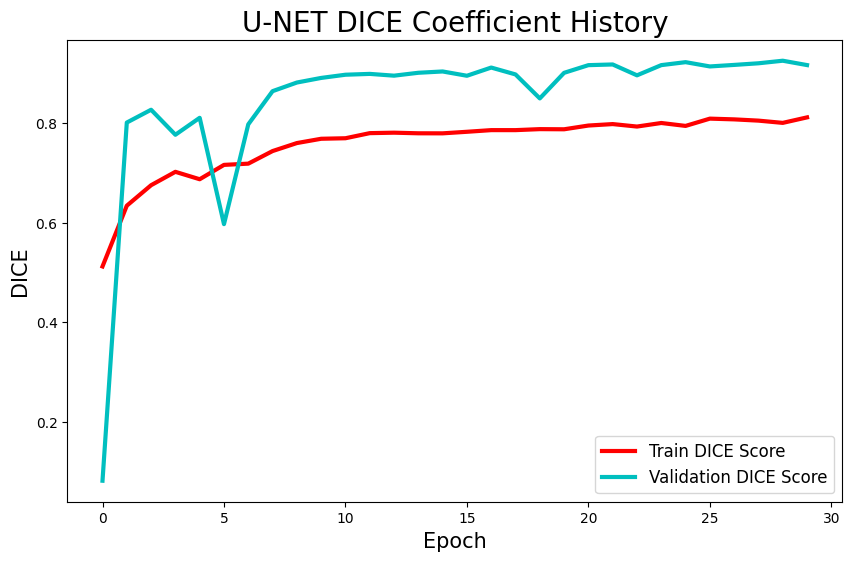

In [28]:
# Function to plot Dice coefficient history across epochs.
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE Score', lw=3, c="r")
    plt.plot(x, val_dice_history, label='Validation DICE Score', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('U-NET DICE Coefficient History', train_dice_history, val_dice_history, num_epochs)

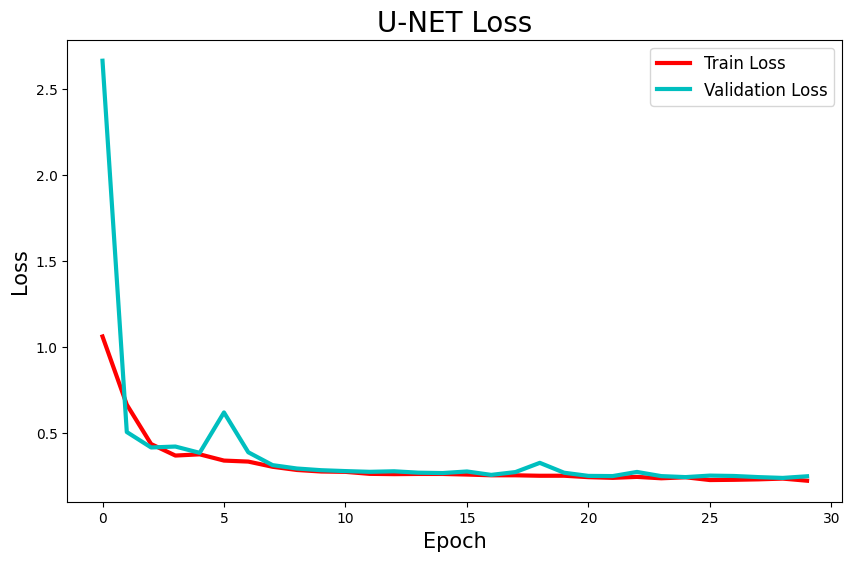

In [29]:
# Function to plot loss history across epochs.
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    x = np.arange(num_epochs)
    
    # Convert PyTorch tensors to NumPy (Move to CPU first if needed)
    train_loss_history = np.array([t.cpu().item() if torch.is_tensor(t) else t for t in train_loss_history])
    val_loss_history = np.array([t.cpu().item() if torch.is_tensor(t) else t for t in val_loss_history])

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="r")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

# Use correct variable names from training output
plot_loss_history('U-NET Loss', train_loss_history, val_loss_history, num_epochs)



## Prediction on Test set

In [30]:
## Saving the Model
torch.save(model.state_dict(), 'brain-mri-unet.pth')

In [31]:
model.load_state_dict(torch.load('brain-mri-unet.pth'))
model.to(device)  # Don't forget to move it to the correct device
model.eval()      # Set to eval mode for inference

/tmp/ipykernel_31/1692916680.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('brain-mri-unet.pth'))


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [32]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Mean DICE: 91.709%, Loss: 0.248
CPU times: user 962 ms, sys: 85.1 ms, total: 1.05 s
Wall time: 1.04 s


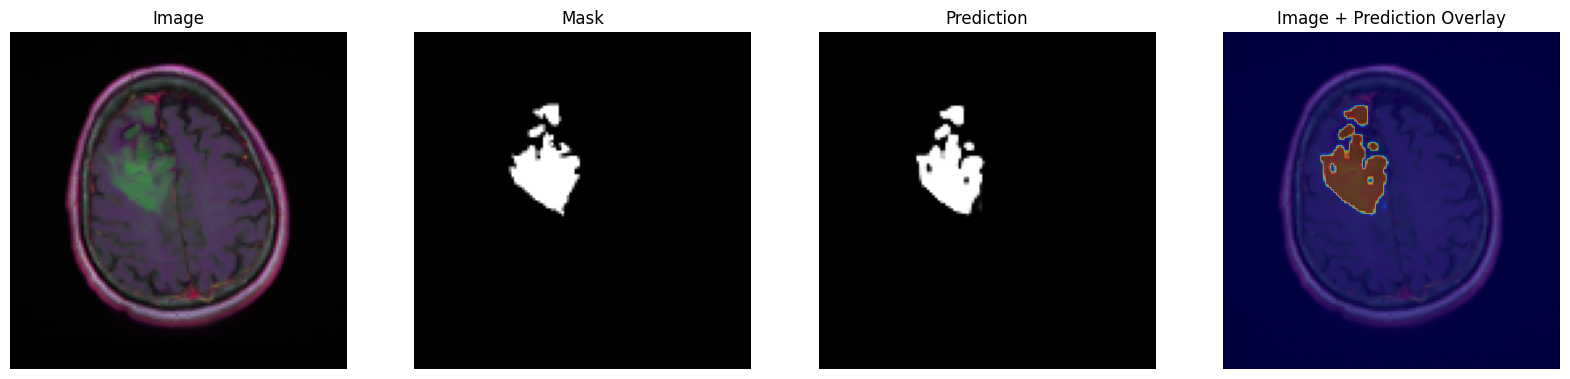

In [33]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Prediction
input_image = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
input_image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(input_image)
pred = model(input_image.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

# Create an overlay image
overlay = image.copy()
overlay[pred > 0.5, 1] = 255  # Green for prediction

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis('off')

ax[2].imshow(pred, cmap='gray')
ax[2].set_title("Prediction")
ax[2].axis('off')

ax[3].imshow(image)
ax[3].imshow(pred, cmap='jet', alpha=0.5)
ax[3].set_title("Image + Prediction Overlay")
ax[3].axis('off')

plt.show()

In [35]:
## Saving the Model
torch.save(model.state_dict(), 'brain-mri-unet.pth')

/tmp/ipykernel_31/1877302376.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


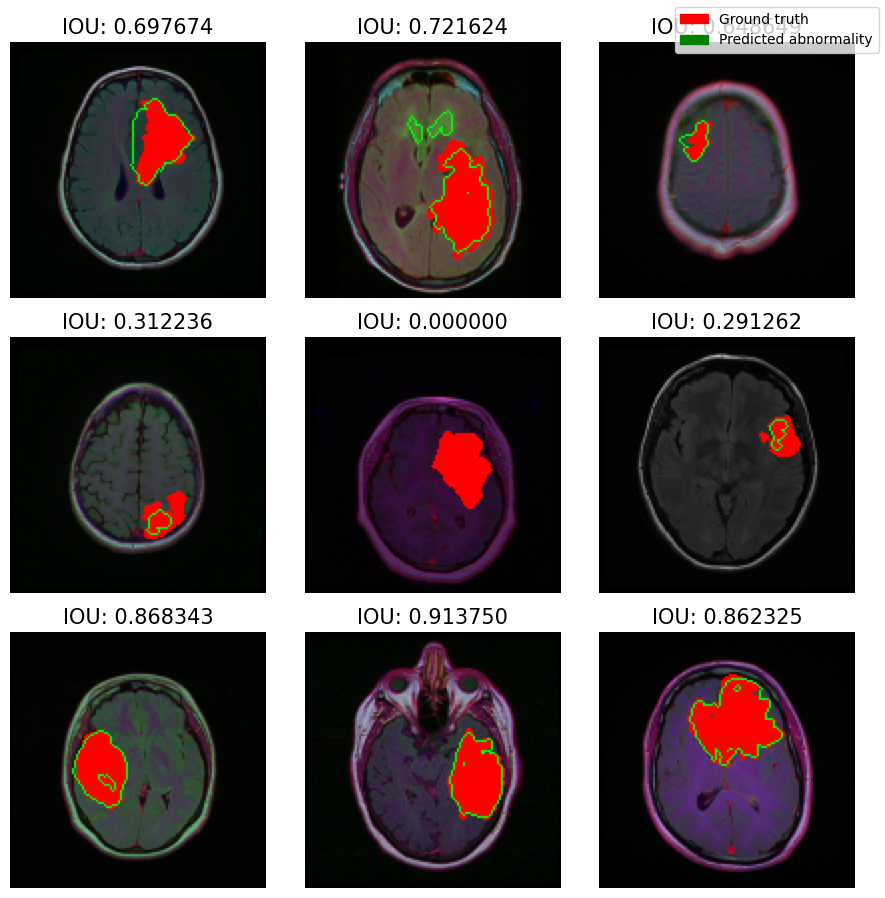

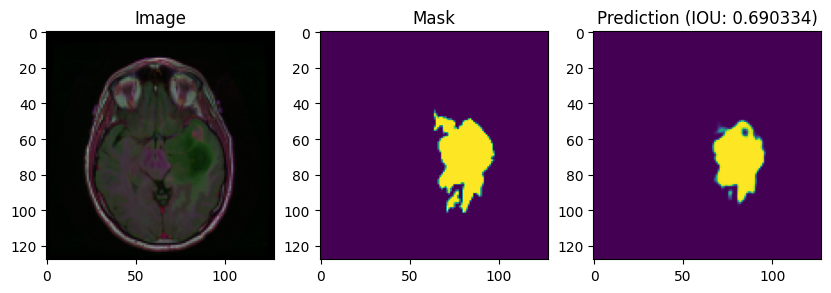

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torchvision.transforms as tt
from skimage.morphology import binary_dilation

# Function to compute Intersection over Union (IoU)
def compute_iou(prediction, mask):
    prediction = prediction.bool()
    mask = mask.bool()
    intersection = (prediction & mask).float().sum()
    union = (prediction | mask).float().sum()
    iou_score = (intersection + 1e-7) / (union + 1e-7)
    return iou_score.item()

# Set device and model (assuming you have `model` defined)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Visualizing segmentation results with IoU scores
%matplotlib inline
figure_width = 3
figure_columns = 3
num_examples = figure_columns * figure_width
fig, axes = plt.subplots(figure_columns, figure_width, figsize=(3 * figure_width, 3 * figure_columns), constrained_layout=True)

# Add legend for the colors used in the visualization
fig.legend(loc='upper right', handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')
])

example_index = 0

with torch.no_grad():
    for idx in range(num_examples):
        # Select a sample from the test set with diagnosis label 1
        test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
        image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
        mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

        # Prediction
        image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
        image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
        prediction = model(image_tensor.to(device))
        prediction = prediction.detach().cpu().numpy()[0, 0, :, :]
        prediction_bin = torch.tensor(prediction > 0.5).int()

        # Compute IoU
        iou_score = compute_iou(prediction_bin, torch.tensor(mask).int())

        # Generate edges for visualization
        prediction_edges = prediction_bin - binary_dilation(prediction_bin)
        ground_truth_edges = torch.tensor(mask) - binary_dilation(torch.tensor(mask))

        # Overlay edges on the image for visualization
        overlay_image = image.copy()
        overlay_image[ground_truth_edges.bool()] = [255, 0, 0]  # Red for ground truth edges
        overlay_image[prediction_edges.bool()] = [0, 255, 0]    # Green for predicted edges

        # Display the segmented image with IoU score
        axes[example_index // figure_width][example_index % figure_width].imshow(overlay_image)
        axes[example_index // figure_width][example_index % figure_width].set_title(f'IOU: {iou_score:.6f}', fontsize=15)
        axes[example_index // figure_width][example_index % figure_width].axis('off')
        
        example_index += 1
        if example_index >= num_examples:
            break

plt.tight_layout()
plt.show()

# Additional script to visualize a single sample with its prediction, ground truth, and IoU score

# Select a sample from the test set with diagnosis label 1 and resize image and mask
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

# Prediction
image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
prediction = model(image_tensor.to(device))
prediction = prediction.detach().cpu().numpy()[0, 0, :, :]

# Compute IoU for the single sample
iou_score = compute_iou(torch.tensor(prediction > 0.7), torch.tensor(mask))

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(prediction)
ax[2].set_title(f'Prediction (IOU: {iou_score:.6f})')

plt.show()

/tmp/ipykernel_31/1877302376.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


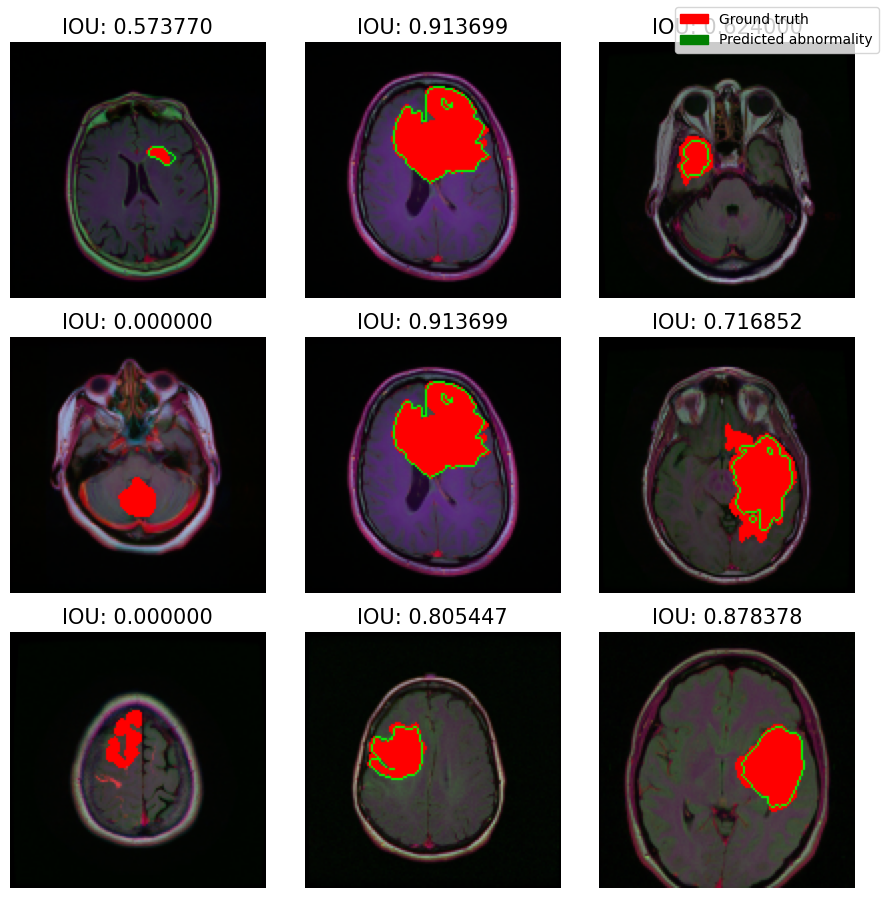

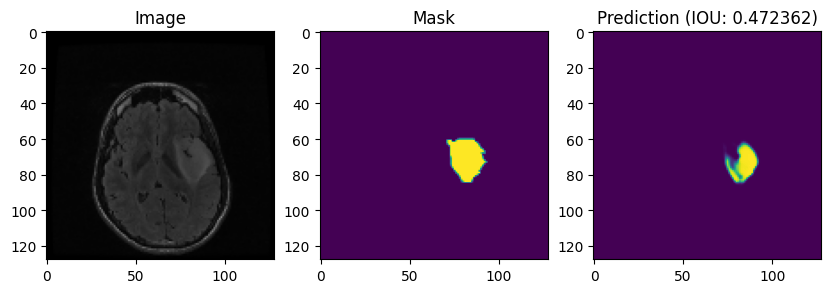

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torchvision.transforms as tt
from skimage.morphology import binary_dilation

# Function to compute Intersection over Union (IoU)
def compute_iou(prediction, mask):
    prediction = prediction.bool()
    mask = mask.bool()
    intersection = (prediction & mask).float().sum()
    union = (prediction | mask).float().sum()
    iou_score = (intersection + 1e-7) / (union + 1e-7)
    return iou_score.item()

# Set device and model (assuming you have `model` defined)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Visualizing segmentation results with IoU scores
%matplotlib inline
figure_width = 3
figure_columns = 3
num_examples = figure_columns * figure_width
fig, axes = plt.subplots(figure_columns, figure_width, figsize=(3 * figure_width, 3 * figure_columns), constrained_layout=True)

# Add legend for the colors used in the visualization
fig.legend(loc='upper right', handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')
])

example_index = 0

with torch.no_grad():
    for idx in range(num_examples):
        # Select a sample from the test set with diagnosis label 1
        test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
        image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
        mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

        # Prediction
        image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
        image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
        prediction = model(image_tensor.to(device))
        prediction = prediction.detach().cpu().numpy()[0, 0, :, :]
        prediction_bin = torch.tensor(prediction > 0.5).int()

        # Compute IoU
        iou_score = compute_iou(prediction_bin, torch.tensor(mask).int())

        # Generate edges for visualization
        prediction_edges = prediction_bin - binary_dilation(prediction_bin)
        ground_truth_edges = torch.tensor(mask) - binary_dilation(torch.tensor(mask))

        # Overlay edges on the image for visualization
        overlay_image = image.copy()
        overlay_image[ground_truth_edges.bool()] = [255, 0, 0]  # Red for ground truth edges
        overlay_image[prediction_edges.bool()] = [0, 255, 0]    # Green for predicted edges

        # Display the segmented image with IoU score
        axes[example_index // figure_width][example_index % figure_width].imshow(overlay_image)
        axes[example_index // figure_width][example_index % figure_width].set_title(f'IOU: {iou_score:.6f}', fontsize=15)
        axes[example_index // figure_width][example_index % figure_width].axis('off')
        
        example_index += 1
        if example_index >= num_examples:
            break

plt.tight_layout()
plt.show()

# Additional script to visualize a single sample with its prediction, ground truth, and IoU score

# Select a sample from the test set with diagnosis label 1 and resize image and mask
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

# Prediction
image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
prediction = model(image_tensor.to(device))
prediction = prediction.detach().cpu().numpy()[0, 0, :, :]

# Compute IoU for the single sample
iou_score = compute_iou(torch.tensor(prediction > 0.7), torch.tensor(mask))

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(prediction)
ax[2].set_title(f'Prediction (IOU: {iou_score:.6f})')

plt.show()

In [62]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_metrics = {'precision': [], 'recall': [], 'f1': [], 'iou': [], 'dice': []}

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            metrics = calculate_metrics(preds, masks)
            for k in all_metrics:
                # Ensure metrics are moved to CPU and converted to a scalar value if they are tensors
                all_metrics[k].append(metrics[k].cpu().item() if isinstance(metrics[k], torch.Tensor) else metrics[k])

    # Convert all metric lists to numpy arrays and compute their mean
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}

    print("\n=== Model Evaluation on Test Set ===")
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

evaluate_model(model, test_dl, device)


=== Model Evaluation on Test Set ===
Precision: 0.8951
Recall: 0.7522
F1: 0.8152
Iou: 0.6906
Dice: 0.8152


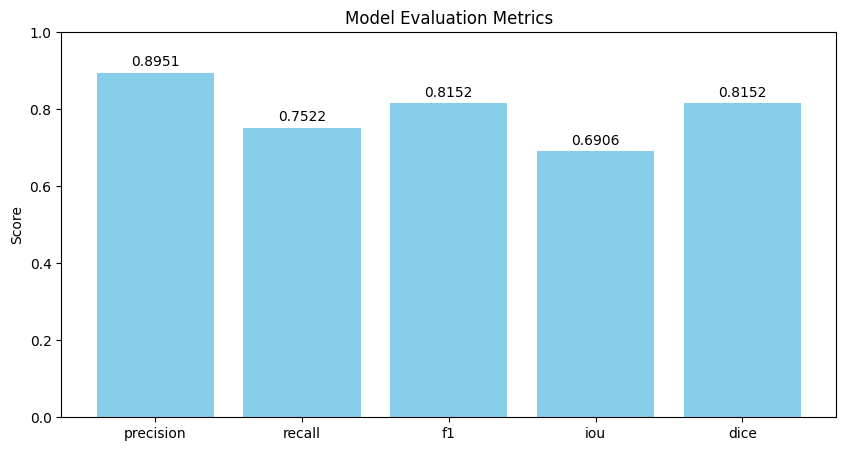

In [41]:
import matplotlib.pyplot as plt

def plot_evaluation_results(metrics_dict):
    metrics_names = list(metrics_dict.keys())
    values = [metrics_dict[k] for k in metrics_names]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(metrics_names, values, color='skyblue')
    plt.ylim(0, 1)
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Score")

    # Add values on top of bars
    for bar, val in zip(bars, values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{val:.4f}", ha='center', va='bottom')

    plt.show()

# Example usage
metrics = {
    'precision': 0.8951,
    'recall': 0.7522,
    'f1': 0.8152,
    'iou': 0.6906,
    'dice': 0.8152
}

plot_evaluation_results(metrics)


In [42]:
torch.save(model, 'brain-mri-unet-full.pth')  # Saves entire model (not just weights)


In [43]:
model = torch.load('brain-mri-unet-full.pth')
model.eval()


/tmp/ipykernel_31/3724888846.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('brain-mri-unet-full.pth')


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

EXTERNAL IMAGE PREDICTION


In [67]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path, size=128):
    """
    Load and preprocess the external image as 3-channel RGB.
    """
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Resize to match model input size
    img_resized = cv2.resize(img, (size, size))

    # Convert grayscale to 3-channel by stacking
    img_3ch = np.stack([img_resized] * 3, axis=-1)  # Shape: (H, W, 3)

    # Normalize and convert to tensor
    img_normalized = img_3ch / 255.0
    img_tensor = torch.tensor(img_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, 3, H, W)

    return img_tensor, img_resized


def predict_external_image(model, image_path, device='cuda', size=128):
    model.eval()

    # Preprocess external image
    img_tensor, original_img = preprocess_image(image_path, size=size)
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()

    return original_img, pred_mask

def plot_prediction(original_img, pred_mask):
    """
    Visualize original image with predicted tumor mask.
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original MRI")
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Tumor Mask")
    plt.imshow(original_img, cmap='gray')
    plt.imshow(pred_mask, cmap='Reds', alpha=0.5)  # Red overlay
    plt.axis('off')

    plt.tight_layout()
    plt.show()



/tmp/ipykernel_31/2488576285.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('brain-mri-unet.pth', map_location=device))


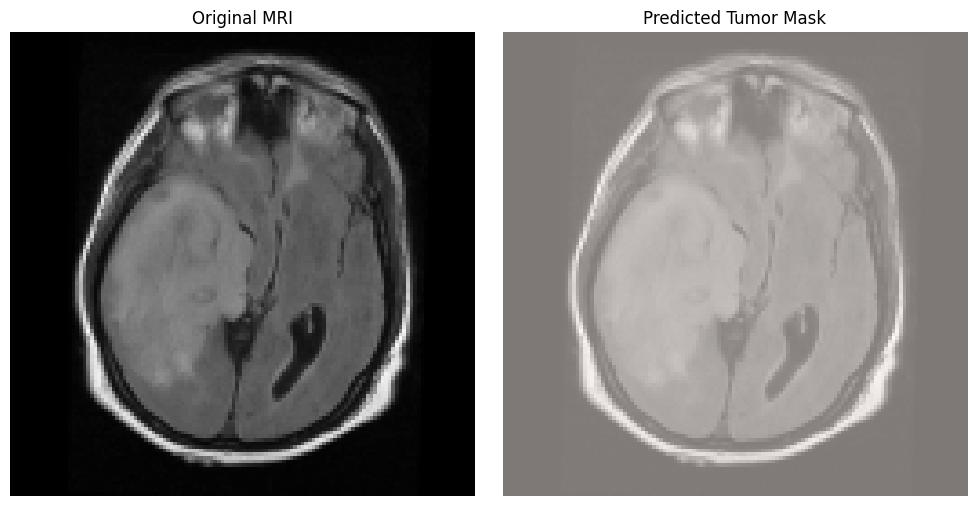

In [70]:
# Load your trained model
model.load_state_dict(torch.load('brain-mri-unet.pth', map_location=device))
model.to(device)

# Path to your external image (you can upload or provide full path)
image_path = r"/kaggle/input/imagepositivetumor/image positive.tif"


# Predict and show result
original_img, pred_mask = predict_external_image(model, image_path, device=device)
plot_prediction(original_img, pred_mask)

/tmp/ipykernel_31/4185828365.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('brain-mri-unet.pth', map_location=device))


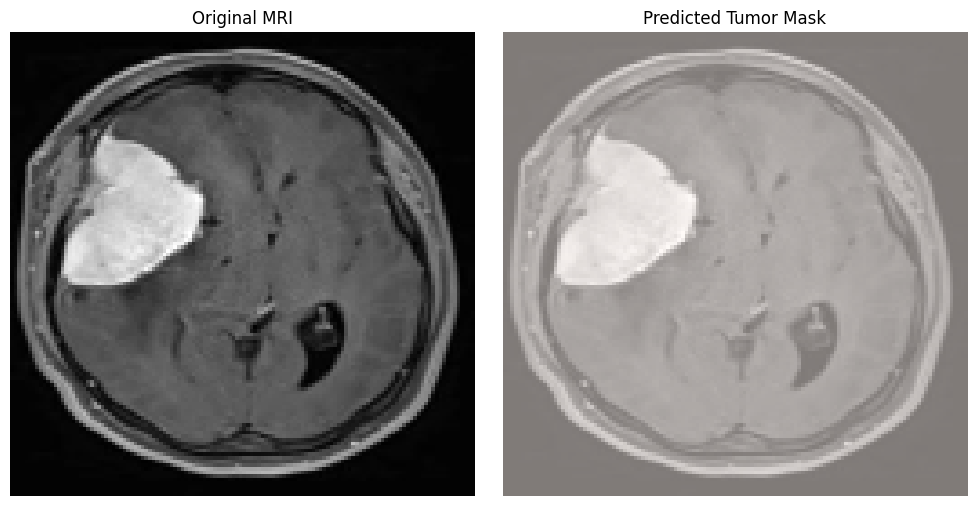

In [69]:
# Load your trained model
model.load_state_dict(torch.load('brain-mri-unet.pth', map_location=device))
model.to(device)

# Path to your external image (you can upload or provide full path)
image_path = r"/kaggle/input/external-image/Y243.JPG"


# Predict and show result
original_img, pred_mask = predict_external_image(model, image_path, device=device)
plot_prediction(original_img, pred_mask)


In [77]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, opening, disk

def preprocess_external_image(image_path, target_size=128):
    """
    Enhanced preprocessing for external brain MRI images.
    Handles both grayscale and color, applies contrast enhancement,
    normalizes based on training data.
    """
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    h, w = img_gray.shape
    scale = min(target_size/h, target_size/w)
    img_resized = cv2.resize(img_gray, (int(w*scale), int(h*scale)))
    
    pad_h = target_size - img_resized.shape[0]
    pad_w = target_size - img_resized.shape[1]
    img_padded = cv2.copyMakeBorder(img_resized, 
                                    pad_h//2, pad_h - pad_h//2,
                                    pad_w//2, pad_w - pad_w//2,
                                    cv2.BORDER_REFLECT)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_enhanced = clahe.apply(img_padded)
    
    img_3ch = np.stack([img_enhanced]*3, axis=-1)
    img_normalized = (img_3ch / 255.0 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    
    img_tensor = torch.tensor(img_normalized, dtype=torch.float32).permute(2,0,1).unsqueeze(0)
    
    return img_tensor, img_padded

def adaptive_threshold(pred, base_thresh=0.3, percentile=None):
    """
    Thresholding with optional adaptive adjustment.
    If percentile is provided, adjusts threshold based on prediction distribution.
    """
    if percentile is not None:
        dynamic_thresh = np.percentile(pred, percentile)
        threshold = max(base_thresh, dynamic_thresh)
    else:
        threshold = base_thresh
    return (pred > threshold).astype(np.uint8)

def postprocess_mask(pred_mask, min_area=50):
    """
    Morphological cleanup of the binary prediction mask.
    Removes small objects and applies opening.
    """
    cleaned = remove_small_objects(pred_mask.astype(bool), min_size=min_area)
    cleaned = opening(cleaned, disk(2))
    return cleaned.astype(np.uint8)

def predict_external_image(model, image_path, device='cuda', target_size=128,
                           base_thresh=0.3, percentile=None, show_hist=False):
    """
    Full prediction pipeline for external images.
    Includes preprocessing, model prediction, adaptive thresholding, and postprocessing.
    """
    model.eval()
    
    img_tensor, original_img = preprocess_external_image(image_path, target_size=target_size)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        pred_prob = torch.sigmoid(output).squeeze().cpu().numpy()
    
    # Optional: Show histogram to debug threshold selection
    if show_hist:
        plt.hist(pred_prob.ravel(), bins=50)
        plt.title("Prediction Probability Histogram")
        plt.xlabel("Probability")
        plt.ylabel("Pixel Count")
        plt.show()
    
    binary_pred = adaptive_threshold(pred_prob, base_thresh=base_thresh, percentile=percentile)
    final_mask = postprocess_mask(binary_pred)
    
    return original_img, pred_prob, final_mask

def plot_enhanced_prediction(original_img, pred_prob, final_mask):
    """
    Visualization showing:
    - Original MRI
    - Probability heatmap
    - Final binary mask
    - Overlay with tumor highlighted
    """
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original MRI", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    heatmap = plt.imshow(pred_prob, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f"Prediction Probability\nMax: {pred_prob.max():.3f}", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(final_mask, cmap='gray')
    plt.title(f"Final Mask\nActive Pixels: {final_mask.sum()}", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(original_img, cmap='gray')
    plt.imshow(final_mask, cmap='Reds', alpha=0.5)
    plt.title("Tumor Segmentation Overlay", fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


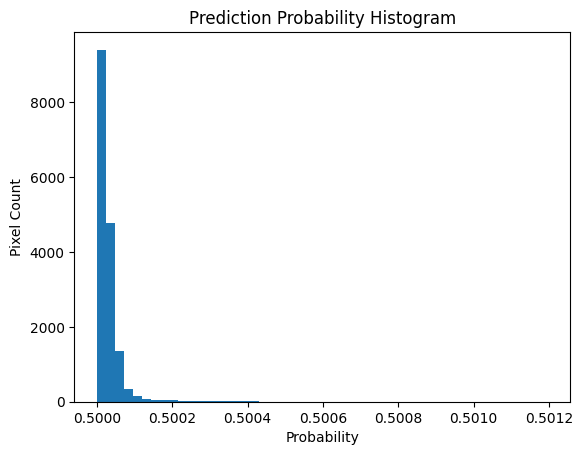

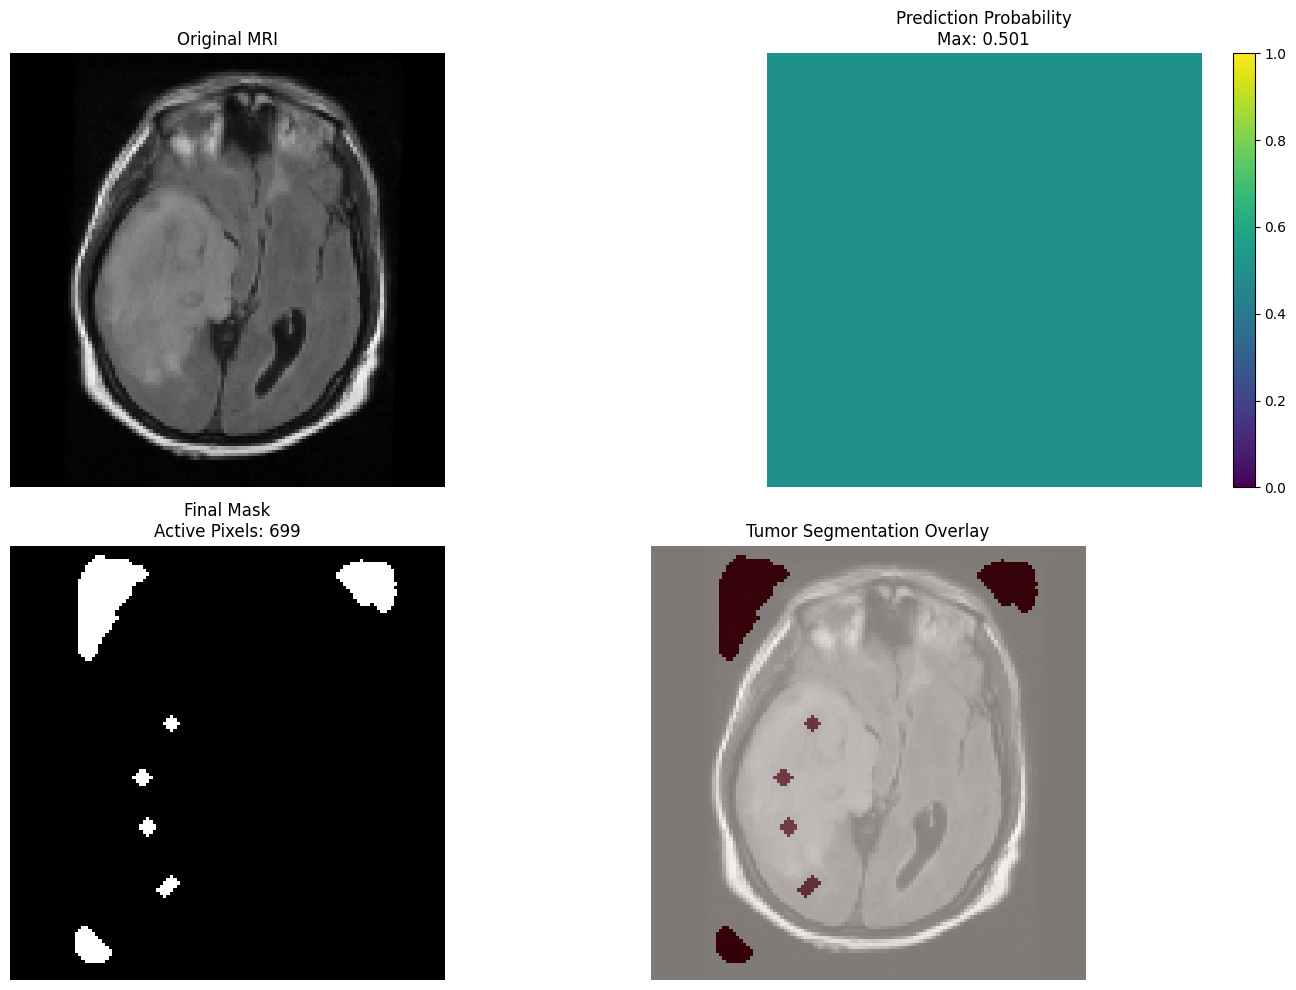

In [78]:
# Assuming you already have a trained model loaded like:
# model = YourUNetModel().to('cuda')
# model.load_state_dict(torch.load('your_model.pth'))

image_path = r"/kaggle/input/imagepositivetumor/image positive.tif"

# Make predictions with optional histogram for debugging
img, prob, mask = predict_external_image(model, image_path, device='cuda', base_thresh=0.3, percentile=85, show_hist=True)

# Plot everything
plot_enhanced_prediction(img, prob, mask)


/tmp/ipykernel_31/1937799338.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('brain-mri-unet.pth', map_location=device))


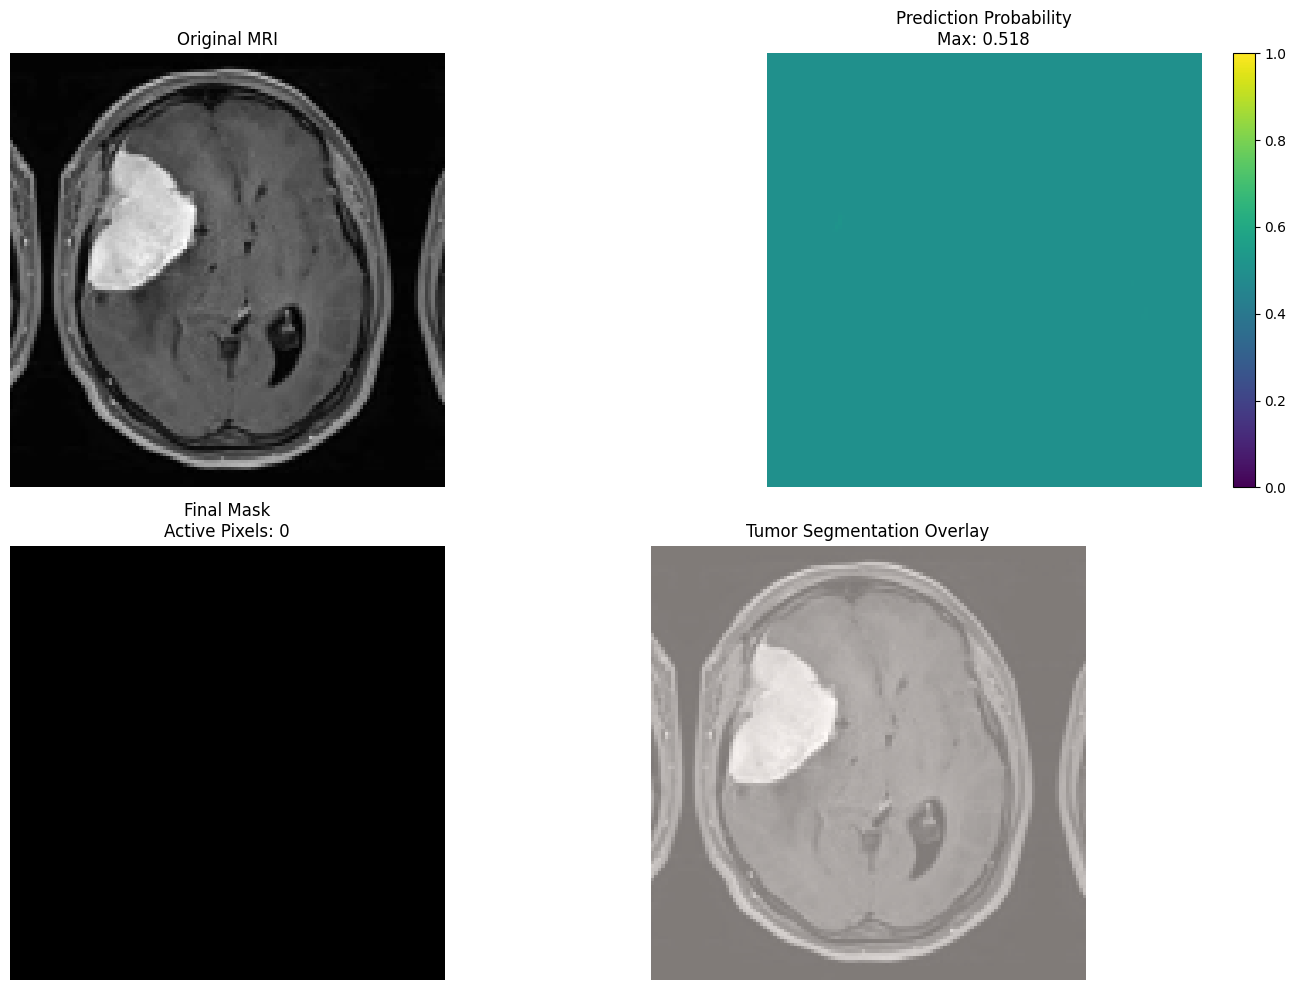

In [76]:
model.load_state_dict(torch.load('brain-mri-unet.pth', map_location=device))
model.to(device)

img, prob, mask = predict_external_image(model, r"/kaggle/input/external-image/Y243.JPG")
plot_enhanced_prediction(img, prob, mask)

Output shape: torch.Size([1, 1, 128, 128])


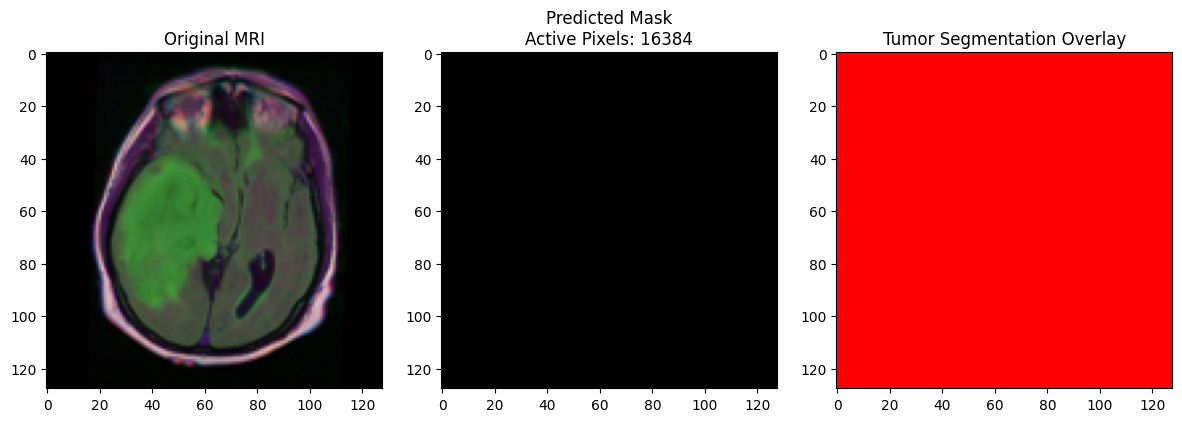

In [82]:
# ====================
# 1. Import Libraries
# ====================
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# 2. UNet Model Definition
# ========================
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return torch.sigmoid(self.conv_last(dec1))

# =========================
# 3. Initialize and Test Model
# =========================
model = UNet(3, 1).to(device)

# Run a dummy input through the model to verify it works
dummy_input = torch.randn(1, 3, 128, 128).to(device)
out = model(dummy_input)
print("Output shape:", out.shape)

# =========================
# 4. Load and Preprocess External Image
# =========================
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    """
    Loads and preprocesses the image from a given path.
    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired size for resizing the image.
    
    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    try:
        # Load the image
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
        return img_tensor
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Example of how to load an external image
# Change 'img_path' to your desired image file path
img_path = r"/kaggle/input/imagepositivetumor/image positive.tif"
img_tensor = load_and_preprocess_image(img_path)

if img_tensor is not None:
    # =========================
    # 5. Run Model Prediction
    # =========================
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)

    # Convert prediction to mask
    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # =========================
    # 6. Visualization
    # =========================
    plt.figure(figsize=(12, 6))

    # Original MRI
    plt.subplot(1, 3, 1)
    plt.imshow(img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title("Original MRI")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Predicted Mask\nActive Pixels: {np.sum(mask)}")

    # Overlay
    plt.subplot(1, 3, 3)
    overlay = np.array(img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)).copy()
    overlay[mask == 1] = [255, 0, 0]  # red tumor regions
    plt.imshow(overlay)
    plt.title("Tumor Segmentation Overlay")

    plt.tight_layout()
    plt.show()
else:
    print("Image preprocessing failed.")
